On souhaite **classer des images de cellules sanguines** en utilisant un CNN. Les images sont groupées en 11 classes :

- **BA** : BAsophiles
- **BNE** : NEutrophiles de Bande
- **EO** : EOsinophiles
- **ERB** : ERythroBlastes
- **LY** : LYmphocytes
- **MMY** : MétaMYélocytes
- **MO** : MOnocytes
- **MY** : MYélocytes
- **PLT** : PLaqueTtes
- **PMY** : Promyélocytes
- **SNE** : NEutrophiles Segmentés

L'approche choisie est le **Transfer Learning** : on utilise le modèle **VGG19** et les poids optimisés pour ImageNet. Ensuite, on procède au **fine tuning des dernières couches de VGG19** (le block 5). On utilise notamment Grad-CAM pour analyser les prédictions du modèle.

Les images ne proviennent que du dataset de Barcelone.

# Modules, connexion au Drive, vérification du GPU

In [1]:
## Gives access to the Drive
from google.colab import drive
drive.mount('/content/drive')

## Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

import sys, os
from pathlib import Path
import shutil
import glob
import itertools

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping

from tensorflow.keras.utils import Sequence
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

sys.path.append('/content/drive/MyDrive/Leukopy')
import leukopy_lib as leuko
from importlib import reload

reload(leuko)

Mounted at /content/drive


<module 'leukopy_lib' from '/content/drive/MyDrive/Leukopy/leukopy_lib.py'>

In [2]:
## GPU status verification
tf.test.gpu_device_name()

## GPU type verification
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Oct 27 07:26:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    35W / 250W |    345MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import et préprocessing des données

## Fonctions

In [4]:
def choose_classes(df_train, df_test, df_valid, n_classes = 11):
  """ Pour travailler avec 11 ou 8 classes. Les BL (blastes) sont une classe de cellules minoritaires provenant d'un dataset différent de celui fournissant les
  images des N-1 autres classes. En raison d'un biais évident, nous ne travaillons pas avec ces images.
  """
  # Option à 11 classes, sans les BL
  if n_classes == 11:
    df_train = df_train[df_train["label"] != "BL"]
    df_test = df_test[df_test["label"] != "BL"]
    df_valid = df_valid[df_valid["label"] != "BL"]

  # Option à 8 classes (IG, SNE et BNE dans la même classe "NEU"), sans les BL :
  if n_classes == 8:

    # Elimine les BL :
    df_train = df_train[df_train["label"] != "BL"]
    df_test = df_test[df_test["label"] != "BL"]
    df_valid = df_valid[df_valid["label"] != "BL"]

    # Renomme SNE/BNE en NEU :
    df_train["label_3"] = df_train["label_3"].replace(to_replace = ["SNE","BNE"], value = ["NEU","NEU"])
    df_valid["label_3"] = df_valid["label_3"].replace(to_replace = ["SNE","BNE"], value = ["NEU","NEU"])
    df_test["label_3"] = df_test["label_3"].replace(to_replace = ["SNE","BNE"], value = ["NEU","NEU"])

    # Sélectionne les label_3 comme labels :
    df_train["label"] = df_train["label_3"]
    df_test["label"] = df_test["label_3"]
    df_valid["label"] = df_valid["label_3"]

  return n_classes, df_train, df_test, df_valid

## Exécution

On **copie localement les données** stockées sur le Drive (gain de temps lors de l'entraînement) et on **génère les dataframes** :

In [ ]:
## Need to copy all the files on the local computer
!cp -r "/content/drive/MyDrive/Leukopy/data/main_dataset.zip" .
!unzip main_dataset.zip

## Create the original dataframes
path = Path('/content/main_dataset/')

df_train = leuko.generate_images_df(path/'training_set')
df_test = leuko.generate_images_df(path/'testing_set')
df_valid = leuko.generate_images_df(path/'validation_set')

On travaille avec 11 classes :

In [5]:
n_classes, df_train, df_test, df_valid = choose_classes(df_train, df_test, df_valid, n_classes = 11)
classes = list(df_train["label"].sort_values().unique())

On découpe chaque jeu de données en **batchs de 32 images**. Les images sont redimensionnées (360x360 pixels) et on programme une **augmentation de données pour le jeu d'entraînement** :

In [6]:
batch_size = 32
img_height  = 360
img_width = 360

train_generator = ImageDataGenerator(rotation_range = 90,
                                     horizontal_flip = True, 
                                     vertical_flip = True)
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # utilise x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (img_height, img_width), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # utilise y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = batch_size,
                                                   shuffle = True,
                                                   preprocessing_function = preprocess_input)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # utilise x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (img_height, img_width), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # utilise y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = batch_size, 
                                                     shuffle = True,
                                                     preprocessing_function = preprocess_input)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # utilise x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (img_height, img_width),
                                                 color_mode = 'rgb',
                                                 classes = None,   # utilise y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = batch_size, 
                                                 shuffle = False, 
                                                 preprocessing_function = preprocess_input)

# Labels/Index connection :
label_map = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

Found 12677 validated image filenames belonging to 11 classes.
Found 1730 validated image filenames belonging to 11 classes.
Found 2544 validated image filenames belonging to 11 classes.
Train : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Valid : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Test  : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}


# Modèle

On construit le modèle :
- base_model contient toutes les couches de VGG19 (sauf la partie classification). Dans un premier temps, **ces couches sont gelées** et ne seront pas entraînées ;
- **la partie classification est remplacée par 3 couches Dense**, séparées les unes des autres par des couches de Dropout. On choisit ReLU comme fonction d'activation des couches Dense (sauf la dernière, activée par Softmax pour qu'elle renvoie des probabilités d'appartenance aux classes)

Le modèle est ensuite compilé :
- on utilise **Adam** comme optimiseur,
- on démarre avec un learning rate de 0.001

In [7]:
inputs = layers.Input(shape = (img_height,img_width,3))
base_model = VGG19(include_top = False,
                   weights = "imagenet",
                   input_tensor = inputs,
                   input_shape = (img_height,img_width,3),
                   pooling = 'avg')
base_model.training = False     # Nécessaire pour le fine-tuning ensuite : sans ça, le modèle est perdu...
base_output = base_model.output # Cette écriture permet d'avoir les couches de "base_model" au même niveau que les couches suivantes (voir model.summary())=> Grad-CAM peut fonctionner
x = layers.Dense(units = 1280, activation = 'relu', name = 'dense_1')(base_output)
x = layers.Dropout(rate = 0.2, name = 'dropout_1')(x)
x = layers.Dense(units = 640, activation = 'relu', name = 'dense_2')(x)
x = layers.Dropout(rate = 0.2, name = 'dropout_2')(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax', name = 'final_softmax')(x)
model = tf.keras.Model(inputs, outputs)

base_model.trainable = False

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

80150528/80134624 [==============================] - 1s 0us/step


In [8]:
# Structure du modèle
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 360, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 360, 360, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 360, 360, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 180, 180, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 180, 180, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 180, 180, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 90, 90, 128)       0     

# Entraînement (attention, des résultats sont affichés, ne pas réexécuter) :

## Partie 1 : Transfer Learning

Dans un premier temps, l'objectif est d'entraîner seulement le bloc de classification du modèle (donc les couches Dense), en utilisant VGG19 pré-entraîné sur ImageNet.

On va attribuer des poids à chaque classe, afin de pénaliser davantage les erreurs que le modèle commet sur les classes les moins représentées du dataset.

In [9]:
def compute_weights(dataset):
  counter = Counter(dataset.classes)                          
  class_weights = {class_id : (1/num_images)*float(sum(counter.values()))/2 for class_id, num_images in counter.items()}
  return class_weights

**Les callbacks vont gérer :**
- la **réduction du learning rate** au cours de l'entraînement, lorsque l'erreur sur le jeu de validation ne diminue plus,
- l'**arrêt de l'entraînement** lorsque que le learning rate minimal a été atteint et que l'erreur sur le jeu de validation ne diminue plus.

On entraîne le modèle pour un maximum de 30 epochs (il ne sera pas atteint) :

In [ ]:
## Training (05/08/2021) - VGG19 with Inf. Mode
# Callbacks
TON = TerminateOnNaN()

control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 2, verbose = 1, mode = 'min', min_lr = 1e-6)
  
early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]
                    
## Compute weights :
class_weights = compute_weights(training_set)

## Training :
epochs = 30
training_history = model.fit(x = training_set, 
                             epochs = epochs,
                             callbacks = callbacks_list,
                             validation_data = validation_set, 
                             class_weight = class_weights)

Epoch 1/30
397/397 [==============================] - 429s 1s/step - loss: 8.0979 - accuracy: 0.5072 - val_loss: 1.0348 - val_accuracy: 0.6156
Epoch 2/30
397/397 [==============================] - 402s 1s/step - loss: 5.1068 - accuracy: 0.6647 - val_loss: 0.7963 - val_accuracy: 0.7208
Epoch 3/30
397/397 [==============================] - 395s 995ms/step - loss: 4.5888 - accuracy: 0.7034 - val_loss: 0.7288 - val_accuracy: 0.7202
Epoch 4/30
397/397 [==============================] - 394s 992ms/step - loss: 4.1705 - accuracy: 0.7309 - val_loss: 0.7245 - val_accuracy: 0.7179
Epoch 5/30
397/397 [==============================] - 394s 992ms/step - loss: 4.0813 - accuracy: 0.7397 - val_loss: 0.6426 - val_accuracy: 0.7636
Epoch 6/30
397/397 [==============================] - 392s 986ms/step - loss: 3.8984 - accuracy: 0.7559 - val_loss: 0.6370 - val_accuracy: 0.7613
Epoch 7/30
397/397 [==============================] - 392s 987ms/step - loss: 3.7990 - accuracy: 0.7548 - val_loss: 0.6084 - val_a

In [ ]:
## Sauvegarde avant FT
model.save("/content/drive/MyDrive/Leukopy/VGG19_TL_11/model_fullsave_trainfalse")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/VGG19_TL_11/model_fullsave_trainfalse/assets


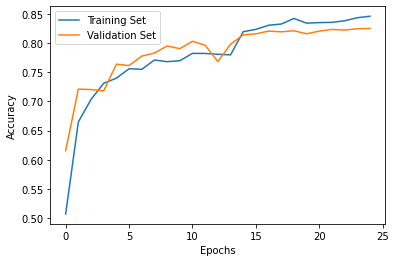

In [ ]:
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(early_stopping.stopped_epoch), training_accuracy[0:early_stopping.stopped_epoch], label = 'Training Set')
plt.plot(np.arange(early_stopping.stopped_epoch), validation_accuracy[0:early_stopping.stopped_epoch], label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

On obtient une accuracy globale de 84% sur le jeu d'entraînement et de 82%~83% sur le jeu de validation.

### Évaluation

In [10]:
# Recharge le modèle si besoin
model = tf.keras.models.load_model("/content/drive/MyDrive/Leukopy/VGG19_TL_11/model_fullsave_trainfalse")

In [11]:
# Évaluation sur les données de test :
model.evaluate(testing_set)

80/80 [==============================] - 39s 226ms/step - loss: 0.4321 - accuracy: 0.8357


[0.4320944547653198, 0.8356918096542358]

On obtient une **accuracy globale de 83~84%** sur le jeu de test. Il n'y a donc **pas d'overfitting** notable.

Pour aller un peu plus dans le détail, nous allons calculer la **matrice de confusion** et des **métriques** adaptées pour chaque classe (rappel, précision, F1-score). La fonction ci-dessous va effectuer cette tâche :

In [12]:
def print_classification_report(testing_set, labels, title):
  """
  Rapport de classification + Matrice de confusion
  """
  # Prédiction : utilise le jeu de test (testing_set)
  predictions = model.predict(testing_set)
  y_pred = tf.argmax(predictions, axis = 1)

  # Calcul et affichage de la matrice de confusion
  cnf_matrix = confusion_matrix(testing_set.classes, y_pred, normalize = 'true')
  classes = range(len(labels))
  
  plt.figure(figsize = (12,12))
  plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
  plt.title("Matrice de confusion - "+title)
  plt.colorbar()

  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels)
  plt.yticks(tick_marks, labels)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), 
                                range(cnf_matrix.shape[1])):
    plt.text(j, i, np.around(cnf_matrix[i, j], decimals = 3),
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  plt.show()

  # Rapport de classification 
  report = classification_report(testing_set.classes, y_pred, target_names = labels, output_dict = True)

  df_report = pd.DataFrame(index = list(report.keys())[:-3], columns = list(report["BA"].keys()))
  for key in list(report.keys())[:-3]:
    for column in list(report["BA"].keys()):
      df_report.loc[key, column] = report[key][column]
  
  print("Classification Report - "+title)
  return y_pred, display(df_report)

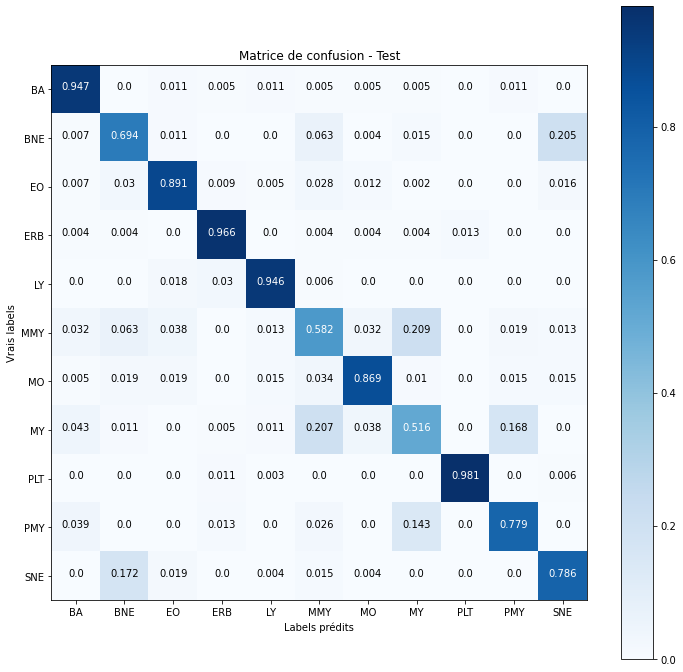

Classification Report - Test


precision    recall  f1-score support
BA   0.886139   0.94709  0.915601     189
BNE  0.712644   0.69403  0.703214     268
EO   0.943627  0.891204  0.916667     432
ERB  0.934694  0.966245  0.950207     237
LY   0.924419  0.946429  0.935294     168
MMY  0.525714  0.582278  0.552553     158
MO      0.895  0.868932  0.881773     206
MY   0.641892  0.516304  0.572289     184
PLT  0.991643  0.980716   0.98615     363
PMY  0.606061  0.779221  0.681818      77
SNE  0.749091   0.78626  0.767225     262

In [13]:
y_pred, df_report = print_classification_report(testing_set, label_map, title = "Test")

On retrouve des performances et des erreurs typiques de ce que nous avons pu rencontrer avec d'autres modèles :
- les plaquettes, les érythroblastes, les éosinophiles, les lymphocytes et les basophiles sont des classes plutôt bien modélisées

- il y a des confusions entre les sous-classes de granulocytes neutrophiles (PMY, MY, MMY, BNE, SNE) : rappelons que ces sous-classes correspondent à des stades différents de la vie d'une même cellule qui évolue continuement d'un stade à l'autre. On remarque ainsi que la principale erreur commise pour les images de PMY (le début de la chaîne) est de les confondre avec les MY. Les MY sont quant à eux essentiellement confondus avec les PMY mais aussi avec les MMY (le stade suivant). Ce raisonnement s'applique à chaque sous-classe de granulocyte.

## Partie 2 : Fine tuning du "block 5"

Maintenant que le bloc de classification a subi un premier entraînement en se basant sur les features extraites par un VGG19 spécialisé sur ImageNet, nous allons ajuster une partie de VGG19 et la réentraîner afin qu'elle se spécialise sur les images de cellules sanguines.

Concrètement, on dégèle toutes les couches appartenant au "block 5" du modèle : ce sont 4 couches de convolution :

block5_conv1 (Conv2D)        (None, 22, 22, 512)       2359808   
_________________________________________________________________
block5_conv2 (Conv2D)        (None, 22, 22, 512)       2359808   
_________________________________________________________________
block5_conv3 (Conv2D)        (None, 22, 22, 512)       2359808   
_________________________________________________________________
block5_conv4 (Conv2D)        (None, 22, 22, 512)       2359808   
_________________________________________________________________


On utilise toujours Adam comme optimiseur et on démarre avec un learning rate plus faible que lors de l'entraînement précédent (on ajuste) : 0.00001.

In [ ]:
## Callbacks
TON = TerminateOnNaN()

control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 3, verbose = 1, mode = 'min', min_lr = 1e-7)
  
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 4, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]
                    
## Compute weights :
class_weights = compute_weights(training_set)

## Unfreeze Block5 + Compile   (Rq: on pourrait essayer de dégeler block4 + block5)
for layer in model.layers:
  if "block5" in layer.name:
    layer.trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5)
model.compile(optimizer = optimizer,
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

Le nombre d'epochs que va durer l'entraînement ainsi que l'ajustement du learning rate au fil de l'eau sont toujours gérés par des callbacks. On pénalise les erreurs commises sur les classes les moins représentées au sein du dataset avec class_weights.

In [ ]:
## Training :
epochs = 30
fine_history = model.fit(x = training_set,
                         epochs = epochs,
                         callbacks = callbacks_list, 
                         validation_data = validation_set, 
                         class_weight = class_weights)

Epoch 1/30
397/397 [==============================] - 410s 1s/step - loss: 2.4579 - accuracy: 0.8548 - val_loss: 0.3515 - val_accuracy: 0.8659
Epoch 2/30
397/397 [==============================] - 406s 1s/step - loss: 1.9932 - accuracy: 0.8827 - val_loss: 0.3530 - val_accuracy: 0.8717
Epoch 3/30
397/397 [==============================] - 404s 1s/step - loss: 1.7783 - accuracy: 0.8987 - val_loss: 0.3019 - val_accuracy: 0.8821
Epoch 4/30
397/397 [==============================] - 404s 1s/step - loss: 1.7235 - accuracy: 0.9014 - val_loss: 0.2759 - val_accuracy: 0.9017
Epoch 5/30
397/397 [==============================] - 405s 1s/step - loss: 1.6049 - accuracy: 0.9053 - val_loss: 0.3057 - val_accuracy: 0.8908
Epoch 6/30
397/397 [==============================] - 405s 1s/step - loss: 1.5353 - accuracy: 0.9109 - val_loss: 0.2563 - val_accuracy: 0.9064
Epoch 7/30
397/397 [==============================] - 405s 1s/step - loss: 1.4784 - accuracy: 0.9106 - val_loss: 0.2983 - val_accuracy: 0.8867

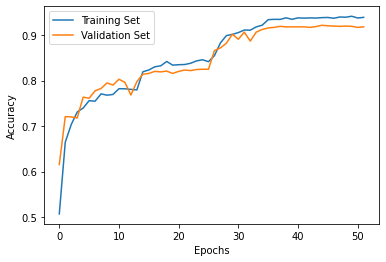

In [ ]:
training_accuracy = training_history.history['accuracy'] + fine_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy'] + fine_history.history['val_accuracy']
training_epochs = len(training_accuracy)

plt.figure()
plt.plot(range(training_epochs), training_accuracy, label = 'Training Set')
plt.plot(range(training_epochs), validation_accuracy, label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

On observe une nette amélioration des performances en termes d'accuracy globale : 93% ~ 94% sur le jeu d'entraînement contre 91% ~ 92% sur ceux de validation et de test. 

In [ ]:
model.evaluate(testing_set)

80/80 [==============================] - 15s 190ms/step - loss: 0.2321 - accuracy: 0.9127


[0.23206640779972076, 0.9127358198165894]

In [ ]:
## Sauvegarde :
model.save("/content/drive/MyDrive/Leukopy/VGG19_TL_11/model_fullsave_ftblock5")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/VGG19_TL_11/model_fullsave_ftblock5/assets


# Évaluation

## Performances et métriques

Commençons par importer le modèle sauvegardé et par mesurer l'accuracy globale sur le jeu de test :

In [14]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Leukopy/VGG19_TL_11/model_fullsave_ftblock5")
model.evaluate(testing_set)

80/80 [==============================] - 15s 185ms/step - loss: 0.2321 - accuracy: 0.9127


[0.2320663332939148, 0.9127358198165894]

**L'amélioration est majeure** par rapport à ce qu'on a pu mesurer à l'issue du premier entraînement. Regardons plus en détail :

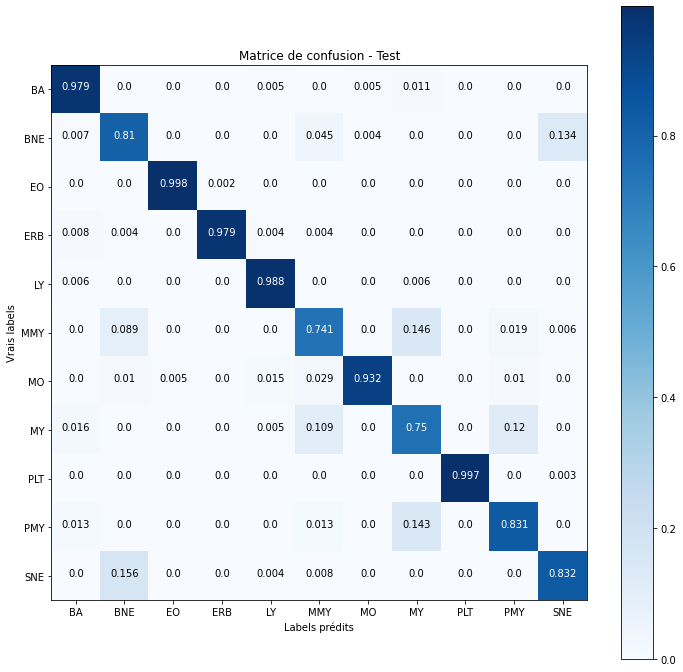

Classification Report - Test


precision    recall  f1-score support
BA   0.953608  0.978836  0.966057     189
BNE  0.789091  0.809701  0.799263     268
EO   0.997685  0.997685  0.997685     432
ERB  0.995708  0.978903  0.987234     237
LY   0.959538  0.988095  0.973607     168
MMY  0.735849  0.740506   0.73817     158
MO   0.989691  0.932039      0.96     206
MY   0.788571      0.75  0.768802     184
PLT         1  0.997245  0.998621     363
PMY  0.703297  0.831169  0.761905      77
SNE  0.851562  0.832061  0.841699     262

In [15]:
y_pred, df_report = print_classification_report(testing_set, label_map, title = "Test")

Le F1-Score de nombreuses classes franchit la barre des 96% : BA, EO, ERB, LY, MO, PLT.

Les F1-Scores mesurés sur la famille des granulocytes neutrophiles sont eux aussi nettement meilleurs.


**Enfin, l'allure de la matrice de confusion est éloquente** quant à la nature des erreurs commises par le modèle : on voit bien que pour les neutrophiles, le modèle a tendance à confondre une sous-classe avec son précuseur immédiat ou avec son successeur immédiat.


**Cela peut indiquer deux choses :**
- **certaines cellules se trouvent peut-être "entre deux"**, présentant des caractéristiques propres à deux voire trois sous-classes consécutives, l'évolution d'une cellule étant un processus continu...
- la **possibilité d'un mauvais étiquetage des données en amont**, à cause de la difficulté de l'exercice, y compris pour un oeil expérimenté.

## Classe par classe avec Grad-CAM

### Fonctions pour Grad-CAM

In [17]:
def get_img_array(img_path, size = (img_height, img_width)):
  """
  Importe une image et applique le preprocessing nécessaire à l'utilisation de VGG19 : batch + preprocess_input
  """
  img_array = tf.keras.preprocessing.image.load_img(img_path, target_size = size)
  img_array = tf.keras.preprocessing.image.img_to_array(img_array)
  img_array = np.expand_dims(img_array, axis = 0)
  img_array = preprocess_input(img_array)

  return img_array


def make_heatmap(img_array, model, last_conv_layer, class_index):
  """
  Calcule la CAM (Class Activation Map) correspondant au label d'indice "class_index" pour l'image "img_array"
  model : un modèle déjà entraîné, dont on désactive la fonction d'activation en sortie (fait dans grandcam())
  last_conv_layer : dernière couche de convolution du modèle. Trouvée automatiquement par la fonction gradcam()
  class_index : renseigné dans l'appel de gradcam() ou trouvé automatiquement par gradcam()
  """
  grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    class_channel = preds[:, class_index]

  grads = tape.gradient(class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

  heatmap_tmp = last_conv_layer_output[0].numpy()

  # Multiplie chaque carte d'activation par le gradient, puis moyenne
  for i in range(last_conv_layer_output.shape[3]):
    heatmap_tmp[:,:,i] *= pooled_grads[i]
  heatmap = np.mean(heatmap_tmp, axis=-1)

  return heatmap


def gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.5, plot = True):

  # Désactive softmax sur la dernière couche :
  model.layers[-1].activation = None

  # Détecte la dernière couche de convolution du modèle :
  for layer in reversed(model.layers):
    if 'conv' in layer.name:
      last_conv_layer = model.get_layer(layer.name)
      break

  # Chargement + preprocessing de l'image (conversion, batch, vgg19 special preprocessing):
  img_array = get_img_array(img_path, size = (img_height, img_width))

  # Choix de la classe à représenter (si class_index non renseigné) :
  if class_index == None :
    # Désactiver Sotfmax sur la couche de sortie :
    #model.layers[-1].activation = None                        # Modif
    # Trouve la classe la plus probable :
    predict = model.predict(img_array)
    class_index = np.argmax(predict[0])

  # Calcul de la CAM : resize pour superposition avec l'image finale
  heatmap = make_heatmap(img_array, model, last_conv_layer, class_index)
  big_heatmap = heatmap

  # Réactive softmax :
  model.layers[-1].activation = tf.keras.activations.softmax

  ## Traitement de la Heatmap
  # Applique ReLu (élimine les valeurs négatives de la heatmap)
  big_heatmap = np.maximum(0, big_heatmap)
  # Normalisation
  big_heatmap = big_heatmap/big_heatmap.max()

  ## Superposition de l'image et de la heatmap 
  # 1/ Import de l'image d'origine
  img = tf.keras.preprocessing.image.load_img(img_path)
  img = tf.keras.preprocessing.image.img_to_array(img)

  # 2/ Rescale heatmap: 0-255
  big_heatmap = np.uint8(255*big_heatmap)
  # 3/ Jet colormap
  jet = cm.get_cmap("jet")
  # 4/ Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[big_heatmap]
  # 5/ Create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
  # 6/ Superimpose the heatmap on original image
  superimposed_img = jet_heatmap*alpha + img
  superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  if plot == True:
    # 7/ Affichage des résultats
    fig = plt.figure(figsize = (8,8))
    fig.add_subplot(1,2,1)
    plt.imshow(big_heatmap)

    fig.add_subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Chosen class : "+str(list(label_map.keys())[class_index]))

  return big_heatmap, superimposed_img

### Exécution

On compile maintenant les résultats dans un dataframe : df_results, et on crée la variable "well_classified" qui indique si le modèle a oui ou non réussi à classer correctement chaque image.

In [16]:
df_results = pd.DataFrame(data = {"label":testing_set.classes,
                                  "label_pred":y_pred, 
                                  "img_path":df_test["img_path"]})

df_results["well_classified"] = np.where(df_results["label"] == df_results["label_pred"], True, False)

Affichons un exemple par classe, tiré au sort, d'image bien classée avec la Grad-CAM associée :

- le modèle arrive à cibler la cellule ou des éléments de la cellule dans la plupart des cas, malgré un peu de déchet (notamment PLT, ERB dans les images ci-dessus, relancer pour changer les images) ;
- lorsque plusieurs cellules d'intérêt figurent sur l'image, le modèle arrive à les trouver (BA, ERB, MY dans les images ci-dessus) ;
- les éléments ciblés par le modèle sont dans certains cas faciles à décoder : les granulations roses pour les EO (pertinent, c'est une caractéristique typique de ces cellules), les filaments reliant les lobes du noyau pour les SNE (idem), les structures alambiquées visibles dans le noyau ou le cytoplasme des monocytes.

In [20]:
fig_gc = plt.figure(figsize = (30,20))

i = 1
for label in np.arange(0,11):

  # Tire un index au hasard parmi les index d'une même classe de cellules
  df_temp = df_results[(df_results["label"] == label) & (df_results["well_classified"] == True)]
  idx = np.random.choice(a = df_temp.index)
        
  img_path = df_temp.loc[idx,"img_path"]

  # Grad-CAM Heatmap + superposition
  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.8, plot = False)

  plt.subplot(4,6,i)
  plt.imshow(plt.imread(img_path))
  plt.title(list(label_map.keys())[label], fontsize = 30)
  plt.grid(None)
  plt.axis('off')

  plt.subplot(4,6,i+1)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')

  i+=2

Output hidden; open in https://colab.research.google.com to view.

#### Plaquettes (PLT)

La Grad-CAM des plaquettes montre du déchet, sur de nombreuses images (mais pas toutes). Si la cellule d'intérêt correspond généralement aux zones rouges de la carte thermique, ce n'est pas toujours le cas.

*On dirait que le modèle, en plus de la cellule sombre au centre de l'image, **recherche également les zones** "blanches", c'est à dire les zones **lumineuses** de l'image. Nous avons remarqué lors de l'exploration que les plaquettes étaient des images pour lesquelles la luminosité moyenne était bien plus élevée que pour les autres classes, elles sortaient du lot.*

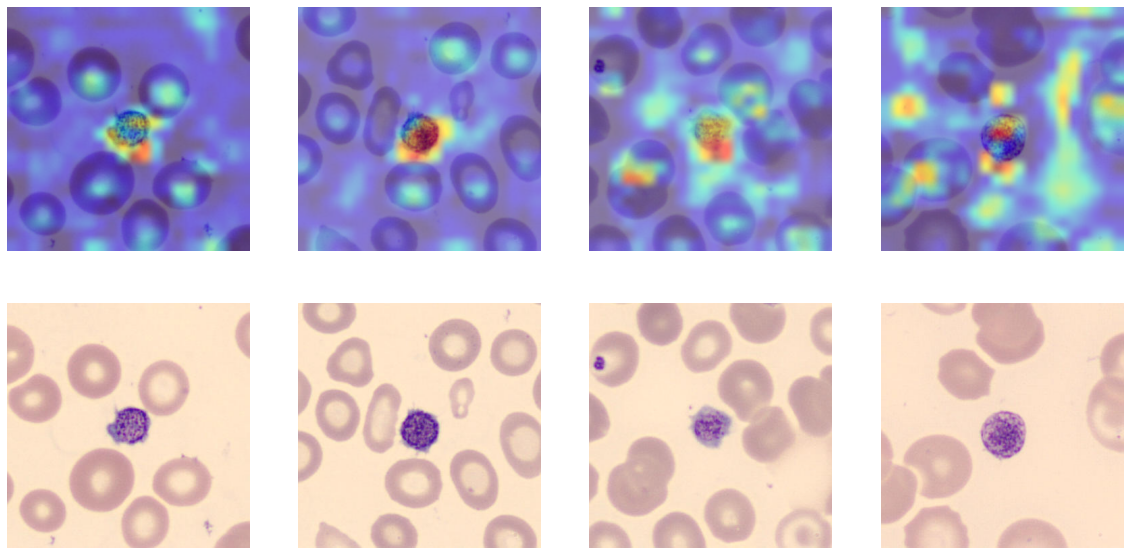

In [23]:
df_PLT = df_results[df_results["label"] == 8]

fig = plt.figure(figsize = (20,10))

for i in range(4):
  idx = np.random.choice(a = df_PLT.index)
  img_path = df_PLT.loc[idx,"img_path"]

  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.8, plot = False)

  plt.subplot(2,4,i+1)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')

  plt.subplot(2,4,i+5)
  plt.imshow(plt.imread(img_path))
  plt.grid(None)
  plt.axis('off')

#### Éosinophiles (EO)

On vérifie bien ce qu'on soupçonnait pour les éosinophiles : **le modèle cible les zones les plus roses de l'image**. Elles correspondent aux granulations éosinophiles qui donnent leur nom à ces cellules.

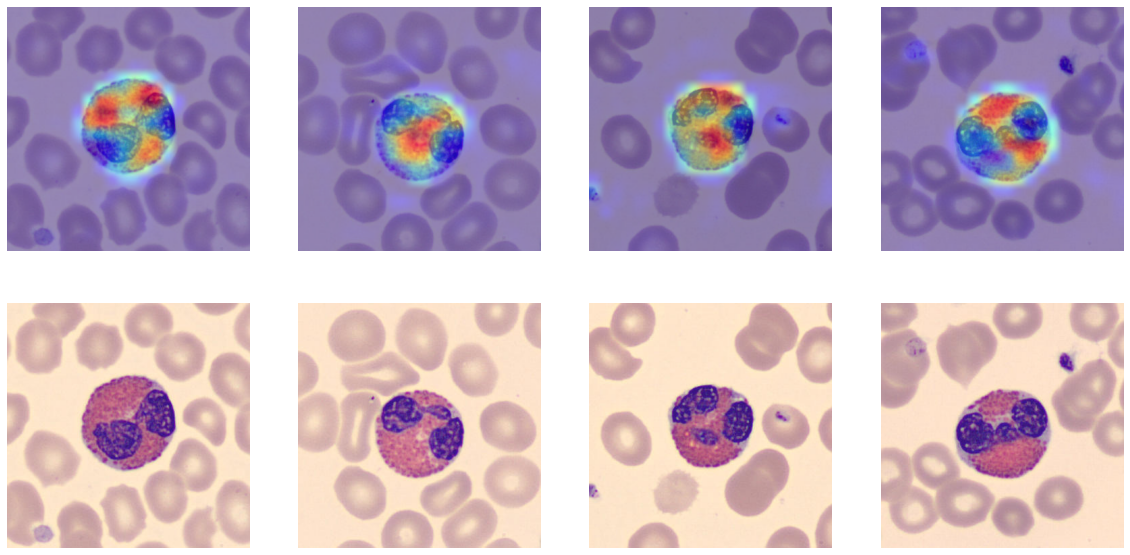

In [24]:
## Cas des EO : on en affiche plusieurs pour voir si on obtient le même type de carte thermique

df_EO = df_results[df_results["label"] == 2]

fig = plt.figure(figsize = (20,10))

for i in range(4):
  idx = np.random.choice(a = df_EO.index)
  img_path = df_EO.loc[idx,"img_path"]

  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.8, plot = False)

  plt.subplot(2,4,i+1)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')

  plt.subplot(2,4,i+5)
  plt.imshow(plt.imread(img_path))
  plt.grid(None)
  plt.axis('off')

#### Neutrophiles segmentés (SNE)

Pour les SNE, la Grad-CAM est plus difficile à interpréter, mais on voit que le modèle cible la cellule et les structures qui se trouvent dans la cellule, notamment le noyau.

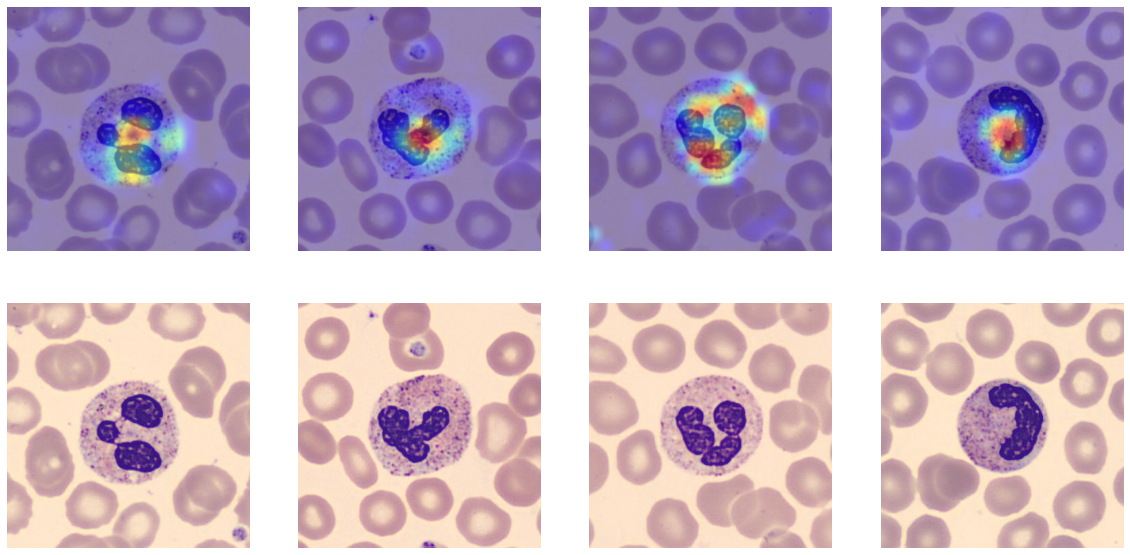

In [26]:
df_SNE = df_results[df_results["label"] == 10]

fig = plt.figure(figsize = (20,10))

for i in range(4):
  idx = np.random.choice(a = df_SNE.index)
  img_path = df_SNE.loc[idx,"img_path"]

  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.8, plot = False)

  plt.subplot(2,4,i+1)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')

  plt.subplot(2,4,i+5)
  plt.imshow(plt.imread(img_path))
  plt.grid(None)
  plt.axis('off')

#### Neutrophiles de bande (BNE)

On rencontre aussi des difficultés pour interpréter Grad-CAM avec les BNE. Le modèle cible la cellule, ce qui est une bonne chose, mais la carte thermique est plus complexe à interpréter :
- on dirait que le modèle recherche le voisinage de la partie concave du noyau (qui a une forme de C assez caractéristique, mais aussi parfois de S...)

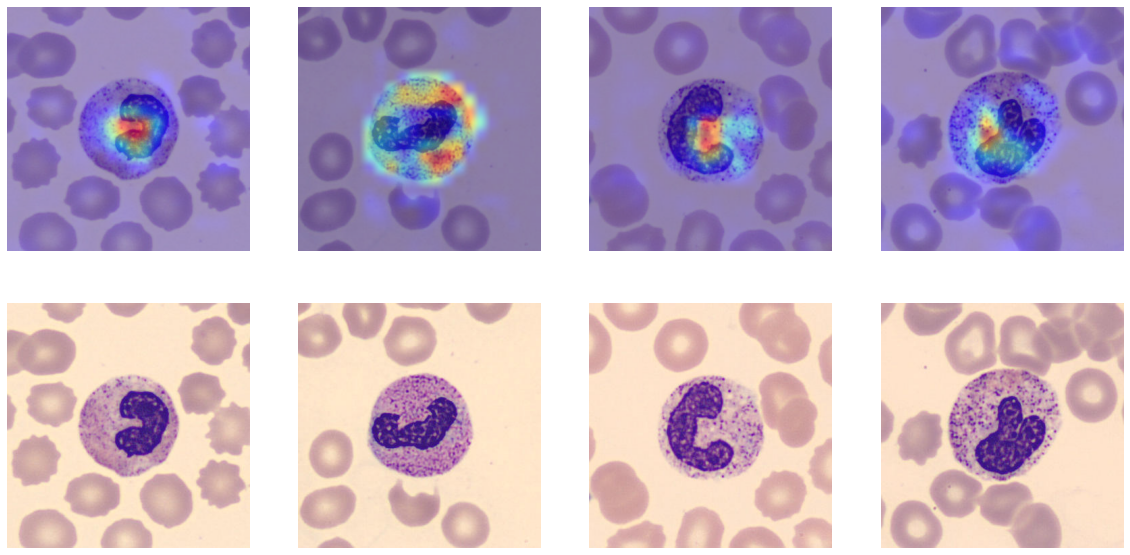

In [27]:
df_BNE = df_results[df_results["label"] == 1]

fig = plt.figure(figsize = (20,10))

for i in range(4):
  idx = np.random.choice(a = df_BNE.index)
  img_path = df_BNE.loc[idx,"img_path"]

  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.8, plot = False)

  plt.subplot(2,4,i+1)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')

  plt.subplot(2,4,i+5)
  plt.imshow(plt.imread(img_path))
  plt.grid(None)
  plt.axis('off')

#### Basophiles (BA)

Les basophiles constituent l'une des classes de cellules les plus sombres du dataset : elles présentent une forte coloration violet sombre. Le modèle semble rechercher cette coloration dans les images, mais c'est ambigü (première et dernière image)

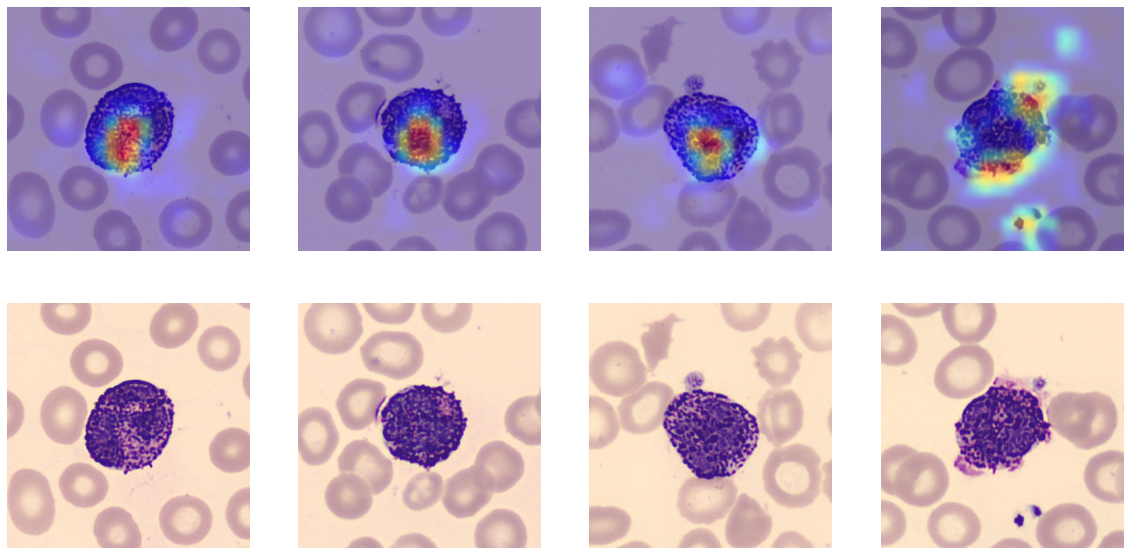

In [28]:
df_BA = df_results[df_results["label"] == 0]

fig = plt.figure(figsize = (20,10))

for i in range(4):
  idx = np.random.choice(a = df_BA.index)
  img_path = df_BA.loc[idx,"img_path"]

  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.8, plot = False)

  plt.subplot(2,4,i+1)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')

  plt.subplot(2,4,i+5)
  plt.imshow(plt.imread(img_path))
  plt.grid(None)
  plt.axis('off')

#### Monocytes (MO)

Comme on l'a remarqué plus haut, le modèle semble être à la recherche de structures "complexes" : formes irrégulières dans le noyau, "trous" dans le cytoplasme. On n'observe ce type de structures que pour les monocytes.

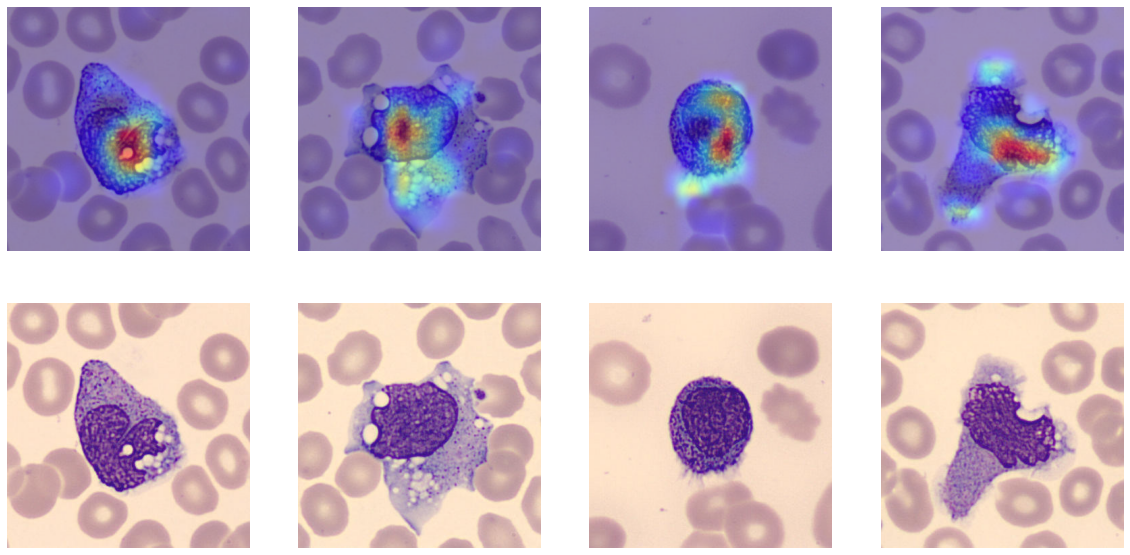

In [ ]:
df_MO = df_results[df_results["label"] == 6]

fig = plt.figure(figsize = (20,10))
for i in range(4):
  idx = np.random.choice(a = df_MO.index)
  img_path = df_MO.loc[idx,"img_path"]
  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.8, plot = False)
  plt.subplot(2,4,i+1)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')
  plt.subplot(2,4,i+5)
  plt.imshow(plt.imread(img_path))
  plt.grid(None)
  plt.axis('off')

# Tuning du "block 4" (bonus)

On tente encore une fois d'améliorer les performances du modèle, et notamment la capacité du modèle à cibler des éléments pertinents de la structure des cellules, en le spécialisant un peu plus.

**On espère obtenir des Grad-CAM plus facilement interprétables**.

Pour cela, on va **ajuster le "block 4" de VGG19**.

## Entraînement

In [ ]:
## Callbacks
TON = TerminateOnNaN()

control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 3, verbose = 1, mode = 'min', min_lr = 1e-8)
  
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 4, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]
                    
## Compute weights :
class_weights = compute_weights(method = 3)

## Unfreeze Block4 + Compile
for layer in model.layers:
  if "block4" in layer.name:
    layer.trainable = True

In [ ]:
## Fine-tuning du block4 :
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6)
model.compile(optimizer = optimizer,
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

## Training :
epochs = 30
tune4_history = model.fit(x = training_set, 
                          epochs = epochs,
                          callbacks = callbacks_list, 
                          validation_data = validation_set, 
                          class_weight = class_weights)

Epoch 1/30
397/397 [==============================] - 424s 1s/step - loss: 1.1165 - accuracy: 0.9333 - val_loss: 0.2293 - val_accuracy: 0.9168
Epoch 2/30
397/397 [==============================] - 418s 1s/step - loss: 1.0545 - accuracy: 0.9388 - val_loss: 0.2326 - val_accuracy: 0.9197
Epoch 3/30
397/397 [==============================] - 417s 1s/step - loss: 1.0395 - accuracy: 0.9382 - val_loss: 0.2351 - val_accuracy: 0.9168
Epoch 4/30
397/397 [==============================] - 415s 1s/step - loss: 1.0253 - accuracy: 0.9395 - val_loss: 0.2198 - val_accuracy: 0.9202
Epoch 5/30
397/397 [==============================] - 416s 1s/step - loss: 0.9935 - accuracy: 0.9415 - val_loss: 0.2220 - val_accuracy: 0.9191
Epoch 6/30
397/397 [==============================] - 418s 1s/step - loss: 1.0239 - accuracy: 0.9397 - val_loss: 0.2131 - val_accuracy: 0.9243
Epoch 7/30
397/397 [==============================] - 417s 1s/step - loss: 1.0202 - accuracy: 0.9408 - val_loss: 0.2276 - val_accuracy: 0.9202

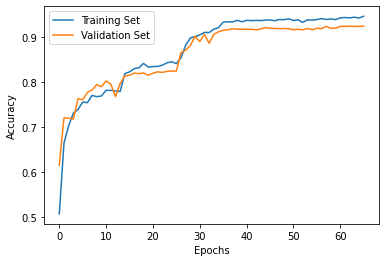

<Figure size 432x288 with 0 Axes>

In [ ]:
training_accuracy = training_accuracy + tune4_history.history['accuracy']
validation_accuracy = validation_accuracy + tune4_history.history['val_accuracy']
training_epochs = len(training_accuracy)

fig = plt.figure()
plt.plot(range(training_epochs), training_accuracy, label = 'Training Set')
plt.plot(range(training_epochs), validation_accuracy, label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.savefig('/content/drive/MyDrive/Leukopy/VGG19_TL_11/training.png')


In [ ]:
model.save("/content/drive/MyDrive/Leukopy/VGG19_TL_11/model_fullsave_ftblock4")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/VGG19_TL_11/model_fullsave_ftblock4/assets


In [29]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Leukopy/VGG19_TL_11/model_fullsave_ftblock4")
model.evaluate(testing_set)

80/80 [==============================] - 15s 186ms/step - loss: 0.2226 - accuracy: 0.9186


[0.22256481647491455, 0.9186320900917053]

On remarquera déjà que **l'accuracy globale n'a guère bougé** par rapport au cas précédent, où seul le block5 avait été ré-entraîné : on obtient toujours 91%~92% pour les jeux de test et de validation.

## Évaluation et Grad-CAM

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Leukopy/VGG19_TL_11/model_fullsave_ftblock4")

### Métriques

Accuracy sur le jeu de test :

In [30]:
model.evaluate(testing_set)

80/80 [==============================] - 15s 187ms/step - loss: 0.2226 - accuracy: 0.9186


[0.22256481647491455, 0.9186320900917053]

Rapport de classification et matrice de confusion :

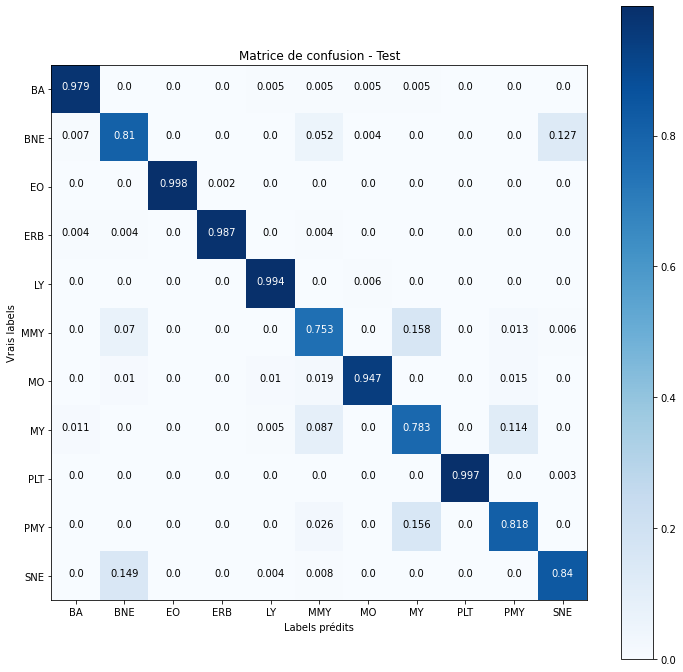

Classification Report - Test


precision    recall  f1-score support
BA   0.973684  0.978836  0.976253     189
BNE  0.803704  0.809701  0.806691     268
EO          1  0.997685  0.998841     432
ERB  0.995745  0.987342  0.991525     237
LY    0.97093  0.994048  0.982353     168
MMY  0.748428  0.753165  0.750789     158
MO   0.984848  0.946602  0.965347     206
MY   0.791209  0.782609  0.786885     184
PLT         1  0.997245  0.998621     363
PMY  0.707865  0.818182  0.759036      77
SNE  0.859375  0.839695  0.849421     262

In [31]:
y_pred, df_report = print_classification_report(testing_set, label_map, title = "Test")

On observe une très légère amélioration des performances lorsqu'on compare ces F1-scores avec les précédents. Il est difficile de savoir si elle est significative dans la mesure où cela concerne seulement quelques images (1 à 2% du support de chaque classe).

In [32]:
df_results = pd.DataFrame(data = {"label":testing_set.classes,
                                  "label_pred":y_pred, 
                                  "img_path":df_test["img_path"]})

df_results["well_classified"] = np.where(df_results["label"] == df_results["label_pred"], True, False)

### Grad-CAM :

On n'observe pas d'amélioration flagrante de l'interprétabilité des cartes thermiques pour les classes où cela posait problème. De plus, il existe toujours des images pour lesquelles Grad-CAM montre du déchet (LY dans l'exemple ci-dessous).

In [38]:
fig_gc = plt.figure(figsize = (30,20))
i = 1
for label in np.arange(0,11):

  # Tire un index au hasard parmi les index d'une même classe de cellules
  df_temp = df_results[(df_results["label"] == label) & (df_results["well_classified"] == True)]
  idx = np.random.choice(a = df_temp.index)
        
  img_path = df_temp.loc[idx,"img_path"]

  # Grad-CAM Heatmap + superposition
  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.8, plot = False)

  plt.subplot(4,6,i)
  plt.imshow(plt.imread(img_path))
  plt.title(list(label_map.keys())[label], fontsize = 30)
  plt.grid(None)
  plt.axis('off')

  plt.subplot(4,6,i+1)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')

  i+=2

Output hidden; open in https://colab.research.google.com to view.

#### Plaquettes (PLT)

Pas d'amélioration notable des problèmes rencontrés précédemment, lorsque seul le block5 était ajusté.

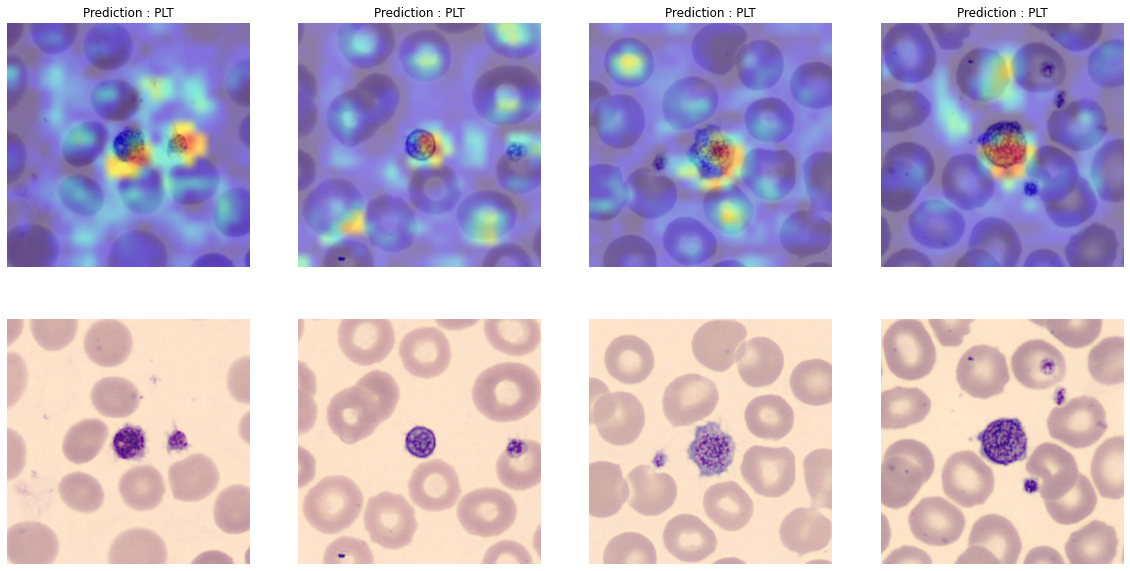

In [44]:
df_temp = df_results[df_results["label"] == 8]

fig = plt.figure(figsize = (20,10))

for i in range(4):
  idx = np.random.choice(a = df_temp.index)
  img_path = df_temp.loc[idx,"img_path"]

  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, class_index = 8, alpha = 0.8, plot = False)

  plt.subplot(2,4,i+1)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')
  plt.title('Prediction : %s'%(classes[df_temp.loc[idx,"label_pred"]]))

  plt.subplot(2,4,i+5)
  plt.imshow(plt.imread(img_path))
  plt.grid(None)
  plt.axis('off')

#### Neutrophiles segmentés (SNE)

Trois images sur quatre sont satisfaisantes : le modèle a repéré un filament du noyau, caractéristique d'un SNE mature. 

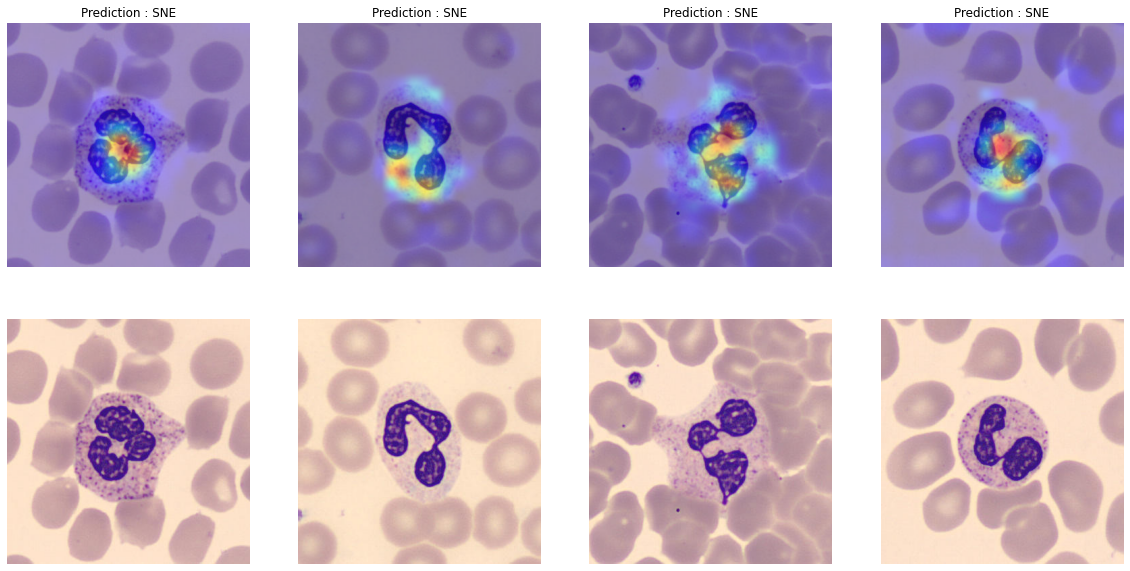

In [46]:
df_temp = df_results[df_results["label"] == 10]

fig = plt.figure(figsize = (20,10))

for i in range(4):
  idx = np.random.choice(a = df_temp.index)
  img_path = df_temp.loc[idx,"img_path"]

  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.8, plot = False)

  plt.subplot(2,4,i+1)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')
  plt.title('Prediction : %s'%(classes[df_temp.loc[idx,"label_pred"]]))

  plt.subplot(2,4,i+5)
  plt.imshow(plt.imread(img_path))
  plt.grid(None)
  plt.axis('off')

#### Neutrophiles de bande (BNE)

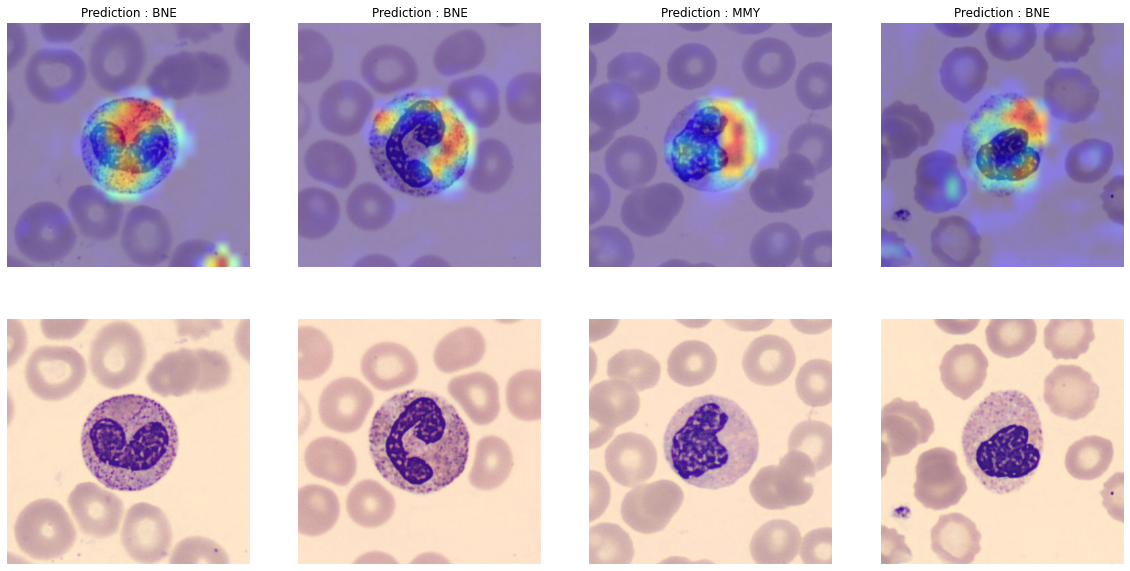

In [48]:
df_temp = df_results[df_results["label"] == 1]

fig = plt.figure(figsize = (20,10))

for i in range(4):
  idx = np.random.choice(a = df_temp.index)
  img_path = df_temp.loc[idx,"img_path"]

  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.8, plot = False)

  plt.subplot(2,4,i+1)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')
  plt.title('Prediction : %s'%(classes[df_temp.loc[idx,"label_pred"]]))

  plt.subplot(2,4,i+5)
  plt.imshow(plt.imread(img_path))
  plt.grid(None)
  plt.axis('off')

# Test du modèle sur le dataset Raabin

Il s'agît ici de tester le modèle développé et optimisé pour Barcelone sur les **données de Raabin**, un dataset complètement indépendant, dans le but d'**évaluer la capacité du modèle à généraliser**.

Les données de Raabin **ne comportent que 5 classes sur nos 11** :
- neutrophiles (a priori matures),
- éosinophiles (EO),
- basophiles (BA),
- lymphocytes (LY),
- monocytes (MO)

## Import et preprocessing

In [ ]:
## Import des données
!cp -r "/content/drive/MyDrive/Leukopy/data/raabin_fulldataset.zip" .
!unzip raabin_fulldataset.zip

On doit adapter les labels de chaque catégorie d'images. On remarquera que les neutrophiles de Raabin comprennent des SNE et des BNE. On identifiera ces images aux SNE (nettement majoritaires devant les BNE) :

In [50]:
path = Path('/content/raabin_fulldataset/')

df_raabin = pd.DataFrame()
df_raabin["img_path"] = [image_path.as_posix() for ext in ['jpg', 'tif', 'png'] for image_path in path.glob(f'**/*.{ext}')]

df_raabin["label"] = [image_path.parts[3] for ext in ['jpg', 'tif', 'png'] for image_path in path.glob(f'**/*.{ext}')]
df_raabin["label"] = df_raabin["label"].replace(to_replace = {"Neutrophil" : "SNE",
                                                              "Lymphocyte" : "LY",
                                                              "Eosinophil" : "EO",
                                                              "Monocyte" : "MO",
                                                              "Basophil" : "BA"} , value = None)

Affichons la composition de ce nouveau dataset, dans lequel les neutrophiles dominent très largement :

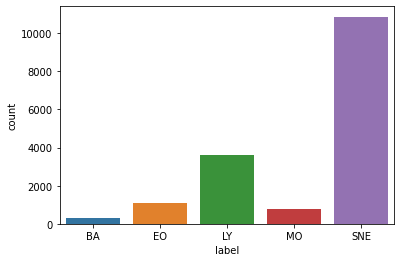

In [56]:
import seaborn as sns
sns.countplot(x = "label", data = df_raabin.sort_values(by = "label"))

Découpage en batchs :

In [51]:
raabin_generator = ImageDataGenerator()

raabin_set = raabin_generator.flow_from_dataframe(
    df_raabin,
    directory = None, # utilise x_col
    x_col = 'img_path',
    y_col = 'label',
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    classes = ['BA', 'BNE', 'EO', 'ERB', 'LY', 'MMY', 'MO', 'MY', 'PLT', 'PMY', 'SNE'],
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = False,
    preprocessing_function = preprocess_input)

Found 16633 validated image filenames belonging to 11 classes.


L'étiquetage est conforme à celui que nous avons pour Barcelone :

In [52]:
label_map_raabin = raabin_set.class_indices
print('Raabin :', raabin_set.class_indices)

Raabin : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}


## Évaluation

Pour avoir un point de comparaison à portée de regard, importons modèle "VGG19 + Tuning du block5" :

In [53]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Leukopy/VGG19_TL_11/model_fullsave_ftblock5")
model.evaluate(testing_set)

80/80 [==============================] - 15s 186ms/step - loss: 0.2321 - accuracy: 0.9127


[0.2320663332939148, 0.9127358198165894]

Évaluons maintenant ce modèle sur le dataset Raabin :

In [54]:
## Test sur Raabin
model.evaluate(raabin_set)

520/520 [==============================] - 136s 260ms/step - loss: 5.8277 - accuracy: 0.1611


[5.827671527862549, 0.16112546622753143]

C'est une **catastrophe** : le modèle ne s'en sort pas puisque seulement 16% des images sont bien classées. Il n'est donc pas capable de généraliser.

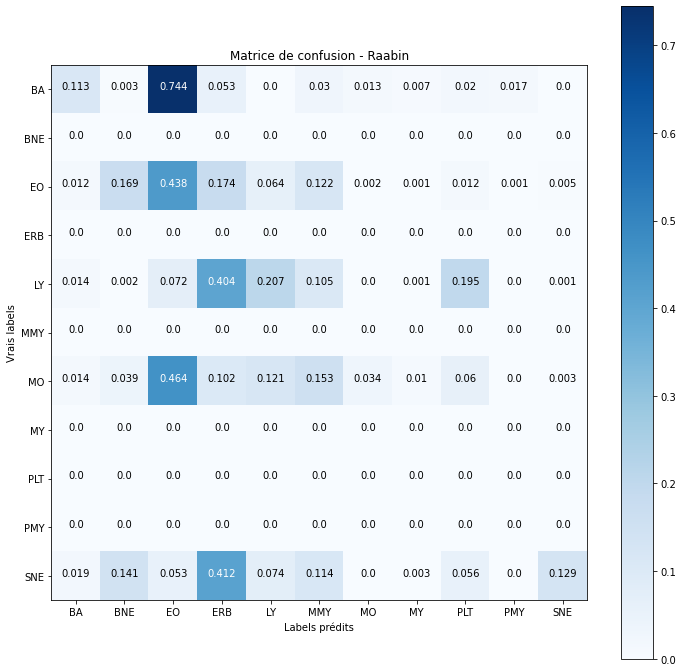

Classification Report - Raabin


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision     recall   f1-score support
BA   0.108974   0.112957    0.11093     301
BNE         0          0          0       0
EO   0.246568   0.438086   0.315541    1066
ERB         0          0          0       0
LY   0.435315   0.206983   0.280563    3609
MMY         0          0          0       0
MO       0.75  0.0339623  0.0649819     795
MY          0          0          0       0
PLT         0          0          0       0
PMY         0          0          0       0
SNE  0.993635    0.12935   0.228902   10862

In [57]:
y_pred_raabin, df_report = print_classification_report(raabin_set, label_map_raabin, title = "Raabin")

Remarquons que les basophiles sont fortement confondus avec des éosinophiles, même si l'inverse n'est pas vrai. Ceci est dû à la coloration des images utilisées pour préparer le dataset Raabin, différente de celle utilisée pour Barcelone : les basophiles prennent une teinte rose, assez similaire à celles des granulations éosinophiles de Barcelone.

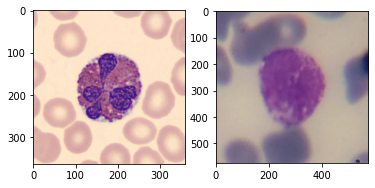

In [63]:
fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(plt.imread("/content/main_dataset/testing_set/EO_455519.jpg"))

fig.add_subplot(1,2,2)
plt.imshow(plt.imread("/content/raabin_fulldataset/Basophil/20190527_111443_0.jpg"))